Data Set Background
-	External data set purchased by SGI
-	Data contains actual quotes issued by SGI brokers from July 2022 to July 2023
-	Field QUOTEID uniquely identifies each quote
-	The first four lowest competitors' premiums, SGI’s premium and the number of carrier’s a broker offers on a quote to a client are given
-	A negative 1 in the data represents a request for the carrier’s default value for a field
-	Variable named success indicates whether SGI got the business or not

Situation

SGI has just purchased the provided dataset from a 3rd party company.  You have been tasked with investigating and analyzing the dataset to develop and model that can predict quote success for the Alberta Homeowners market – we are interested in the home product only. 

### importing needed packages

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import os
import numpy as np
import pandas as pd
import plotly.express as px
import pgeocode
import plotly.graph_objects as go
import pyproj
from shapely.geometry import Point
from datetime import datetime as dt
import category_encoders as ce

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import DMatrix

from h2o.grid import H2OGridSearch
from sklearn.model_selection import train_test_split

In [2]:
import h2o

h2o.init()
from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\Tolu\miniconda3\envs\sgi\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Tolu\AppData\Local\Temp\tmpy03i2dxm
  JVM stdout: C:\Users\Tolu\AppData\Local\Temp\tmpy03i2dxm\h2o_Tolu_started_from_python.out
  JVM stderr: C:\Users\Tolu\AppData\Local\Temp\tmpy03i2dxm\h2o_Tolu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       America/Toronto
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.3
H2O_cluster_version_age:    13 days
H2O_cluster_name:           H2O_from_python_Tolu_bovc65
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.990 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.16 final
--------------------------  -----------------------------

The link to the AB_ER_2021.shp file can be found on the province of Alberta's site: https://www.alberta.ca/geographic-geospatial-statistics#jumplinks-0

In [106]:
df = pd.read_excel("Data/DataSet - Data Scientist Assessment.xlsx", "in")
coldesc = pd.read_excel("Data/ColumnDescription.xlsx", "Sheet1")
ab_shp4 = gpd.read_file("Data/AB_ER_2021.shp")
print("The shape of the original dataframe is:", df.shape)

The shape of the original dataframe is: (95267, 109)


In [4]:
df_homeowners = df.loc[df.DwellingType.str.lower() == "homeowners"]

In [5]:
df_homeowners.loc[
    df_homeowners.NumberOfYearsSinceLastClaim.isna(), "NumberOfYearsSinceLastClaim"
] = -1
df_homeowners.loc[df_homeowners.SecondaryHeat.isna(), "SecondaryHeat"] = "NONE"
df_homeowners.loc[df_homeowners.PoolType.isna(), "PoolType"] = "No Pool"
df_homeowners.loc[df_homeowners.SecondaryHeatDate.isna(), "SecondaryHeatDate"] = "NONE"
df_homeowners.loc[df_homeowners.YearsSinceLastNSF.isna(), "YearsSinceLastNSF"] = -1
df_homeowners.loc[df_homeowners.NonSmoker.isna(), "NonSmoker"] = 0
df_homeowners.loc[df_homeowners.SBUAmount.isna(), "SBUAmount"] = 0
df_homeowners.loc[df_homeowners.EQBldgAmount.isna(), "EQBldgAmount"] = 0
df_homeowners.drop(
    columns=["EQContsAmount", "LivingAreaMeasure", "PrimaryHeatDate"], inplace=True
)
df_homeowners.loc[
    df_homeowners.NumberOfYearsSinceLastWaterClaim.isna(),
    "NumberOfYearsSinceLastWaterClaim",
] = -1
df_homeowners["QuoteDATE"] = pd.to_datetime(
    df_homeowners["QuoteDATE"], format="%d%b%Y:%H:%M:%S.%f"
)
df_homeowners["QuoteDATE"] = df_homeowners["QuoteDATE"].dt.date
df_homeowners["month"] = pd.to_datetime(df_homeowners["EffDATE"]).dt.month
df_homeowners["quarter"] = pd.to_datetime(df_homeowners["EffDATE"]).dt.quarter
df_homeowners["year"] = pd.to_datetime(df_homeowners["EffDATE"]).dt.year
df_homeowners.loc[
    df_homeowners["RequestedDeductible"] == -1, "RequestedDeductible"
] = 500
df_homeowners.loc[df_homeowners["QuotedDeductible"] == -1, "QuotedDeductible"] = 500
df_homeowners.loc[df_homeowners["SBUReqDeduct"] == -1, "SBUReqDeduct"] = 1.0e02
df_homeowners.loc[df_homeowners["SBUReqAmount"] == -1, "SBUReqAmount"] = 1.0e00
df_homeowners.loc[df_homeowners["SBUReqAmount"] == -2, "SBUReqAmount"] = 1.111e07
df_homeowners.loc[
    df_homeowners["RequestedContentsLimit"] == -1, "RequestedContentsLimit"
] = 0.0000e00
df_homeowners.loc[
    df_homeowners["RequestedOutbuildingsLimit"] == -1, "RequestedOutbuildingsLimit"
] = 0.000000e00
df_homeowners.loc[df_homeowners["liability_limit"] == -1, "liability_limit"] = 1000000


df_homeowners.loc[df_homeowners["ExteriorFinish"].isna(), "ExteriorFinish"] = "Unknown"
df_homeowners.loc[
    df_homeowners["ConstructionType"].isna(), "ConstructionType"
] = "OTHER"
df_homeowners.loc[
    df_homeowners["ElectricalWiringType"].isna(), "ElectricalWiringType"
] = "UNKNOWN"
df_homeowners.loc[df_homeowners["RoofType"].isna(), "RoofType"] = "OTHER"

C:\Users\Tolu\AppData\Local\Temp\ipykernel_16804\3298475047.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_homeowners.drop(
C:\Users\Tolu\AppData\Local\Temp\ipykernel_16804\3298475047.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_homeowners["QuoteDATE"] = pd.to_datetime(
C:\Users\Tolu\AppData\Local\Temp\ipykernel_16804\3298475047.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [6]:
def get_lat_lon(postal_code):
    nomi = pgeocode.Nominatim("ca")
    location = nomi.query_postal_code(postal_code)
    return [location.latitude], [location.longitude]


gdf = df_homeowners.copy()

uni_pos = list(gdf["PostalCode"].unique())
lat_lon = {
    pc: gpd.points_from_xy(*get_lat_lon(pc[:3] + " " + pc[3:])) for pc in uni_pos
}

gdf["geometry"] = gdf["PostalCode"].map(lat_lon)
gdf["geometry"] = gdf["geometry"].apply(lambda x: x[0])
gdf.set_geometry("geometry")
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")
print("The shape of dataframe with only homeowners is:", df_homeowners.shape)
print("The shape of dataframe with geometry column added is:", gdf.shape)

The shape of dataframe with only homeowners is: (70391, 109)
The shape of dataframe with geometry column added is: (70391, 110)


GIS dataframe as the shape: (8, 8)


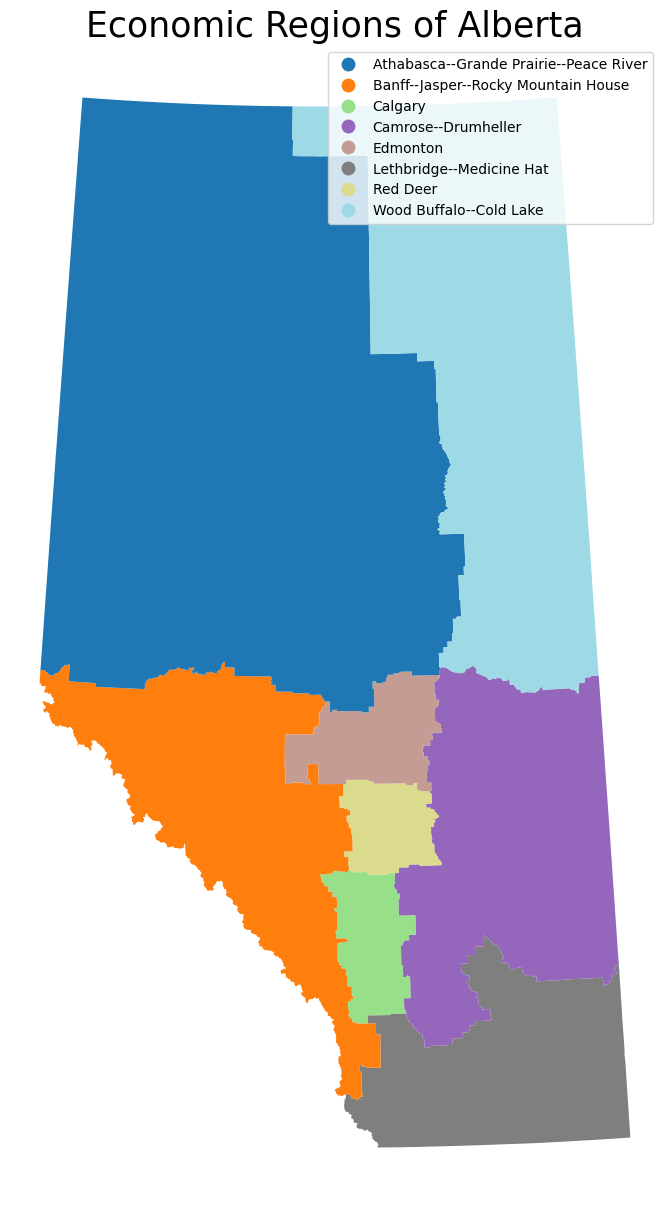

In [7]:
print("GIS dataframe as the shape:", ab_shp4.shape)

# plotting the map of Paris where each district has it's own colour.
fig, ax = plt.subplots(1, figsize=(15, 15))
ab_shp4.plot(cmap="tab20", column="ERNAME", ax=ax, categorical=True, legend=True)
ax.set_title(
    "Economic Regions of Alberta", fontdict={"fontsize": "25", "fontweight": "3"}
)

leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.15, 0.5))
ax.set_axis_off()

plt.savefig("er_ab.png", format="png")
plt.show()

In [8]:
tmp_poly = list(ab_shp4.geometry.unique())
regions = {}
for poly in tmp_poly:
    tmp = list(ab_shp4.loc[ab_shp4["geometry"] == poly]["ERNAME"].unique())[0]
    regions[tmp] = poly


def convert_lat_lon(p):
    # Define the CRS codes for WGS84 (latitude, longitude) and the target CRS (EPSG:3400)
    wgs84_crs = pyproj.CRS("EPSG:4326")  # WGS84 CRS
    target_crs = pyproj.CRS("EPSG:3400")  # Your target CRS

    # Create a transformer to convert between the two CRS
    transformer = pyproj.Transformer.from_crs(wgs84_crs, target_crs, always_xy=True)
    point_wgs84 = p
    point_target_crs = transformer.transform(point_wgs84.y, point_wgs84.x)

    return Point(point_target_crs[0], point_target_crs[1])

In [9]:
for index, row in gdf.iterrows():
    if row["geometry"].is_empty:
        print(f"Geometry at index {index} is empty {row['PostalCode']} {row['City']}")

gdf.loc[(gdf["geometry"].is_empty) & (gdf["City"] == "EDMONTON"), "geometry"] = gdf.loc[
    ~(gdf["geometry"].is_empty) & (gdf["City"] == "EDMONTON")
]["geometry"].iloc[0]


city = "TSUUT'INA"
nomi = pgeocode.Nominatim("ca")
location = nomi.query_postal_code("t3e 2l9")
point = gpd.points_from_xy([location.latitude], [location.longitude])
gdf.loc[(gdf["geometry"].is_empty) & (gdf["City"] == city), "geometry"] = point


for index, row in gdf.iterrows():
    if row["geometry"].is_empty:
        print(f"Geometry at index {index} is empty {row['PostalCode']} {row['City']}")

Geometry at index 6246 is empty T6Y0A1 EDMONTON
Geometry at index 29036 is empty T3T2H7 TSUUT'INA
Geometry at index 46007 is empty T6Y0A1 EDMONTON
Geometry at index 46784 is empty T6Y0A1 EDMONTON
Geometry at index 62190 is empty T6Y3M4 EDMONTON
Geometry at index 67909 is empty T6Y1Y3 EDMONTON
Geometry at index 81597 is empty T6Y0K3 EDMONTON


In [10]:
uni_geo = list(gdf.geometry.unique())
for ge in uni_geo:
    gdf.loc[gdf["geometry"] == ge, "geometry"] = convert_lat_lon(ge)


def find_region(point):
    for reg, polygon in regions.items():
        if point.within(polygon):
            return reg
    return None


uni_geo = list(gdf.geometry.unique())
gdf["ERNAME"] = ""
for ge in uni_geo:
    gdf.loc[gdf["geometry"] == ge, "ERNAME"] = find_region(ge)

In [11]:
merged_df = gdf.merge(ab_shp4, how="right", on="ERNAME")
print("The shape of merged dataframe is:", merged_df.shape)

The shape of merged dataframe is: (70391, 118)


In [12]:
tmp = (
    merged_df.groupby(["ERNAME", "geometry_y"])
    .agg(total_success=("success", "sum"), total_quote=("success", "count"))
    .sort_values("total_success", ascending=False)
    .reset_index()
)

tmp["comp_success"] = tmp["total_quote"] - tmp["total_success"]
tmp["conversion_rate"] = tmp["total_success"] / tmp["total_quote"]
tmp["comp_conversion_rate"] = tmp["comp_success"] / tmp["total_quote"]
tmp = gpd.GeoDataFrame(tmp, geometry="geometry_y")

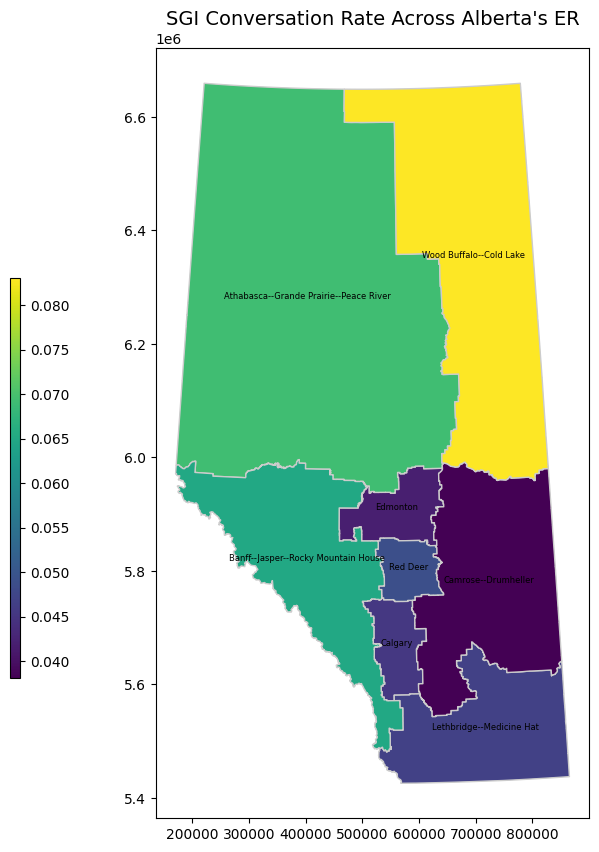

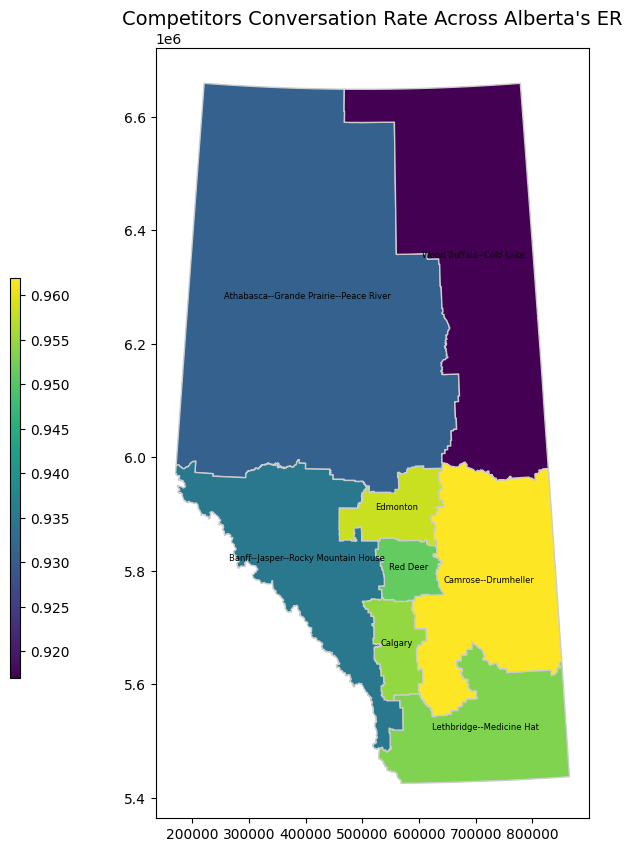

In [13]:
vmin = tmp["conversion_rate"].min()
vmax = tmp["conversion_rate"].max()
cmap = "viridis"

fig, ax = plt.subplots(1, figsize=(10, 10))
tmp.plot(column="conversion_rate", ax=ax, edgecolor="0.8", linewidth=1, cmap=cmap)

# Add a title
ax.set_title(
    "SGI Conversation Rate Across Alberta's ER",
    fontdict={"fontsize": "14", "fontweight": "3"},
)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

tmp.apply(
    lambda x: ax.annotate(
        text=x["ERNAME"], xy=x.geometry_y.centroid.coords[0], ha="center", fontsize=6
    ),
    axis=1,
)
plt.savefig("er_heat_suc.png", format="png")
plt.show()


vmin = tmp["comp_conversion_rate"].min()
vmax = tmp["comp_conversion_rate"].max()
cmap = "viridis"

fig, ax = plt.subplots(1, figsize=(10, 10))
tmp.plot(column="comp_conversion_rate", ax=ax, edgecolor="0.8", linewidth=1, cmap=cmap)

# Add a title
ax.set_title(
    "Competitors Conversation Rate Across Alberta's ER",
    fontdict={"fontsize": "14", "fontweight": "3"},
)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

tmp.apply(
    lambda x: ax.annotate(
        text=x["ERNAME"], xy=x.geometry_y.centroid.coords[0], ha="center", fontsize=6
    ),
    axis=1,
)
plt.savefig("er_heat_fail.png", format="png")
plt.show()

In [14]:
fig = px.bar(
    tmp,
    x="ERNAME",
    y=["comp_conversion_rate", "conversion_rate"],
    title="SGI Conversion Rate Across Alberta's ER",
    labels={"value": "Conversion Rate"},
    opacity=0.9,
    text_auto=".2%",
    orientation="v",
    barmode="group",
    width=900,
    height=600,
)
fig.update_yaxes(tickformat=".2%")
fig.write_image("conversation_rate.png", format="png")
fig.show()

In [15]:
fig = px.bar(
    tmp,
    x="ERNAME",
    y=["comp_success", "total_success"],
    title="SGI Success Count Across Alberta's ER",
    labels={"value": "Quote Count"},
    opacity=0.9,
    orientation="v",
    text_auto=".2s",
    barmode="group",
    width=900,
    height=600,
)
fig.write_image("conversation_count.png", format="png")
fig.show()

In [16]:
tmp = (
    merged_df.groupby(["success"])
    .agg(total_success=("success", "count"))
    .sort_values("total_success", ascending=False)
    .reset_index()
)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="success",
    y="total_success",
    title="SGI Quote Across Alberta's ER",
    labels={"total_success": "Conversion Count"},
    opacity=0.9,
    orientation="v",
    text_auto=".2s",
    color="success",
    barmode="group",
    width=900,
    height=600,
)
fig.write_image("quote_count.png", format="png")
fig.show()

In [17]:
tmp = (
    merged_df.loc[merged_df["success"] == 1]
    .groupby(["ERNAME", "SGI_Premium_Rank"])
    .agg(total_success=("success", "count"))
    .sort_values("total_success", ascending=False)
    .reset_index()
)

fig = px.bar(
    tmp,
    x="ERNAME",
    y="total_success",
    title="SGI Premium Rank Across Alberta's ER - Converted",
    labels={"total_success": "Conversion Count"},
    opacity=0.9,
    color="SGI_Premium_Rank",
    orientation="v",
    barmode="group",
    width=900,
    height=600,
)
fig.write_image("rank_er_suc.png", format="png")
fig.show()


tmp = (
    merged_df.loc[merged_df["success"] == 0]
    .groupby(["ERNAME", "SGI_Premium_Rank"])
    .agg(total_success=("success", "count"))
    .sort_values("total_success", ascending=False)
    .reset_index()
)

fig = px.bar(
    tmp,
    x="ERNAME",
    y="total_success",
    title="SGI Premium Rank Across Alberta's ER - Lost",
    labels={"total_success": "Conversion Count"},
    opacity=0.9,
    color="SGI_Premium_Rank",
    orientation="v",
    barmode="relative",
    width=900,
    height=600,
)
fig.write_image("rank_er_fail.png", format="png")
fig.show()

In [18]:
tmp = (
    merged_df.loc[merged_df["success"] == 1]
    .groupby(["SGI_Premium_Rank", "cnt_company_comp"])
    .agg(total_comp=("cnt_company_comp", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)

fig = px.bar(
    tmp,
    x="cnt_company_comp",
    y="total_comp",
    title="SGI Premium Rank Against Competitors - Successful Conversion",
    labels={"total_comp": "Number of Occurrences"},
    color="SGI_Premium_Rank",
    opacity=0.9,
    orientation="v",
    barmode="stack",
    width=900,
    height=600,
)
fig.write_image("rank_er_suc_com.png", format="png")
fig.show()

tmp2 = (
    merged_df.loc[merged_df["success"] == 0]
    .groupby(["SGI_Premium_Rank", "cnt_company_comp"])
    .agg(total_comp=("cnt_company_comp", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)

fig = px.bar(
    tmp2,
    x="cnt_company_comp",
    y="total_comp",
    title="SGI Premium Rank Against Competitors - Failed Conversion",
    labels={"total_comp": "Number of Occurrences"},
    color="SGI_Premium_Rank",
    opacity=0.9,
    orientation="v",
    barmode="stack",
    width=900,
    height=600,
)
fig.write_image("rank_er_fai_com.png", format="png")
fig.show()

In [19]:
# Create histogram traces for each dataset
trace1 = go.Histogram(
    x=merged_df.loc[merged_df["success"] == 1]["SGI_Premium_Rank"],
    opacity=0.5,
    name="Won",
)
trace2 = go.Histogram(
    x=merged_df.loc[merged_df["success"] == 0]["SGI_Premium_Rank"],
    opacity=0.5,
    name="Lost",
)
trace3 = go.Histogram(x=merged_df["SGI_Premium_Rank"], opacity=0.5, name="Total")
# Create a figure and add the histogram traces
fig = go.Figure(data=[trace1, trace3])

# Update layout and show the plot
fig.update_layout(
    title="SGI Rank Distribution",
    xaxis_title="Rank",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay histograms
)
fig.write_image("rank_histo.png", format="png")

fig.show()

In [20]:
# Create histogram traces for each dataset
trace1 = go.Histogram(
    x=merged_df.loc[merged_df["success"] == 1]["SGI_Premium"], opacity=0.5, name="Won"
)
trace2 = go.Histogram(
    x=merged_df.loc[merged_df["success"] == 0]["SGI_Premium"], opacity=0.5, name="Lost"
)
trace3 = go.Histogram(x=merged_df["SGI_Premium"], opacity=0.5, name="Total")
# Create a figure and add the histogram traces
fig = go.Figure(data=[trace1, trace3])

# Update layout and show the plot
fig.update_layout(
    title="SGI Premium Distribution",
    xaxis_title="Values",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay histograms
)
fig.write_image("histo.png", format="png")

fig.show()

In [21]:
# Create histogram traces for each dataset
trace1 = go.Histogram(
    x=merged_df.loc[merged_df["success"] == 1]["BuildingAge"], opacity=0.5, name="Won"
)
trace2 = go.Histogram(
    x=merged_df.loc[merged_df["success"] == 0]["BuildingAge"], opacity=0.5, name="Lost"
)
trace3 = go.Histogram(x=merged_df["BuildingAge"], opacity=0.5, name="Total")
# Create a figure and add the histogram traces
fig = go.Figure(data=[trace1, trace3])

# Update layout and show the plot
fig.update_layout(
    title="Building Age Distribution",
    xaxis_title="Age",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay histograms
)
fig.write_image("histo_building.png", format="png")

fig.show()

In [22]:
val1 = len(
    merged_df.loc[(merged_df["BuildingAge"] > 25) & (merged_df["success"] == 1)][
        "success"
    ]
)
val2 = len(
    merged_df.loc[(merged_df["BuildingAge"] <= 25) & (merged_df["success"] == 1)][
        "success"
    ]
)
val3 = len(
    merged_df.loc[(merged_df["BuildingAge"] > 25) & (merged_df["success"] == 0)][
        "success"
    ]
)
val4 = len(
    merged_df.loc[(merged_df["BuildingAge"] <= 25) & (merged_df["success"] == 0)][
        "success"
    ]
)

categories = ["25 and Under", "Over 25"]
values1 = [val2, val1]
values2 = [val4, val3]

trace1 = go.Bar(x=categories, y=values1, name="Won", text=values1)
trace2 = go.Bar(x=categories, y=values2, name="Loss", text=values2)

layout = go.Layout(
    title="Quote Count across Building Age",
    xaxis=dict(title="Age"),
    yaxis=dict(title="Amount"),
    barmode="group",
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.update_traces(textposition="auto", texttemplate="%{text:.2s}")
fig.write_image("build_age_bar.png", format="png")
fig.show()

In [23]:
tmp = (
    merged_df.groupby(["YearsSinceLastNSF", "success"])
    .agg(total_comp=("success", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)


tmp["YearsSinceLastNSF"] = tmp["YearsSinceLastNSF"].astype(str)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="YearsSinceLastNSF",
    y="total_comp",
    title="Years Since Last NSF Distribution",
    labels={"total_comp": "Number of Occurrences"},
    opacity=0.9,
    orientation="v",
    color="success",
    barmode="group",
    text_auto=".2s",
    width=900,
    height=600,
)
fig.write_image("yrnsf_bar.png", format="png")
fig.show()

In [24]:
tmp = (
    merged_df.groupby(["NumberOfNSF", "success"])
    .agg(total_comp=("success", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)


tmp["NumberOfNSF"] = tmp["NumberOfNSF"].astype(str)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="NumberOfNSF",
    y="total_comp",
    title="Number of NSF Distribution",
    labels={"total_comp": "Number of Occurrences"},
    opacity=0.9,
    orientation="v",
    color="success",
    barmode="group",
    text_auto=".2s",
    width=900,
    height=600,
)
fig.write_image("nsf_bar.png", format="png")
fig.show()

In [25]:
tmp = (
    merged_df.groupby(["FireAlarmType", "success"])
    .agg(total_comp=("success", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)

tmp["FireAlarmType"] = tmp["FireAlarmType"].astype(str)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="FireAlarmType",
    y="total_comp",
    title="Fire Alarm Type",
    labels={"total_comp": "Number of Occurrences"},
    opacity=0.9,
    orientation="v",
    color="success",
    barmode="group",
    text_auto=".2s",
    width=900,
    height=600,
)
fig.write_image("FireAlarmType.png", format="png")
fig.show()

In [26]:
tmp = (
    merged_df.groupby(["BurglarAlarmType", "success"])
    .agg(total_comp=("success", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)

tmp["BurglarAlarmType"] = tmp["BurglarAlarmType"].astype(str)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="BurglarAlarmType",
    y="total_comp",
    title="Burglar Alarm Type",
    labels={"total_comp": "Number of Occurrences"},
    opacity=0.9,
    orientation="v",
    color="success",
    barmode="group",
    text_auto=".2s",
    width=900,
    height=600,
)
fig.show()

fig.write_image("BurglarAlarmType.png", format="png")

In [27]:
tmp = (
    merged_df.groupby(["ElectricalWiringType", "success"])
    .agg(total_comp=("success", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)

tmp["ElectricalWiringType"] = tmp["ElectricalWiringType"].astype(str)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="ElectricalWiringType",
    y="total_comp",
    title="Electrical Wiring Type",
    labels={"total_comp": "Number of Occurrences"},
    opacity=0.9,
    orientation="v",
    color="success",
    barmode="group",
    text_auto=".2s",
    width=900,
    height=600,
)
fig.write_image("Elec_w.png", format="png")
fig.show()

In [28]:
tmp = (
    merged_df.groupby(["FPC", "success"])
    .agg(total_comp=("success", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)

tmp["FPC"] = tmp["FPC"].astype(str)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="FPC",
    y="total_comp",
    title="Fire Protection Code Distribution",
    labels={"total_comp": "Number of Occurrences"},
    opacity=0.9,
    orientation="v",
    color="success",
    barmode="group",
    text_auto=".2s",
    width=900,
    height=600,
)
fig.write_image("FPC.png", format="png")
fig.show()

In [29]:
tmp = (
    merged_df.groupby(["NonSmoker", "success"])
    .agg(total_comp=("SGI_Premium", "count"))
    .sort_values("total_comp", ascending=False)
    .reset_index()
)

tmp["NonSmoker"] = tmp["NonSmoker"].astype(str)
tmp["success"] = tmp["success"].astype(str)
fig = px.bar(
    tmp,
    x="NonSmoker",
    y="total_comp",
    title="Smoker Distribution",
    labels={"total_comp": "Number of Occurrences"},
    opacity=0.9,
    orientation="v",
    color="success",
    barmode="group",
    text_auto=".2s",
    width=900,
    height=600,
)
fig.write_image("NonSmoker.png", format="png")
fig.show()

In [30]:
merged_df["EffDATE"] = merged_df["EffDATE"].dt.date
merged_df["month"] = pd.to_datetime(merged_df["EffDATE"]).dt.month
merged_df["quarter"] = pd.to_datetime(merged_df["EffDATE"]).dt.quarter
merged_df["year"] = pd.to_datetime(merged_df["EffDATE"]).dt.year

In [31]:
# Create histogram traces for each dataset
trace1 = go.Histogram(
    x=merged_df.loc[(merged_df["success"] == 1)]["EffDATE"], opacity=0.5, name="Won"
)
trace2 = go.Histogram(x=merged_df["EffDATE"], opacity=0.5, name="Total")
# Create a figure and add the histogram traces
fig = go.Figure(data=[trace1, trace2])

# Update layout and show the plot
fig.update_layout(
    title="Quote Distribution",
    xaxis_title="Time",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay histograms
)
fig.write_image("EffDATE.png", format="png")
fig.show()

In [32]:
for col in [
    "NumberOfClaims10years",
    "NumberOfClaims5years",
    "NumberOfClaims3years",
    "NumberOfYearsSinceLastClaim",
    "NumberOfWaterClaims10years",
    "NumberOfWaterClaims5years",
    "NumberOfWaterClaims3years",
    "NumberOfYearsSinceLastWaterClaim",
    "Occupation",
]:
    tmp = (
        merged_df.groupby([col, "success"])
        .agg(total_comp=("success", "count"))
        .sort_values("total_comp", ascending=False)
        .reset_index()
    )

    tmp[col] = tmp[col].astype(str)
    tmp["success"] = tmp["success"].astype(str)
    fig = px.bar(
        tmp,
        x=col,
        y="total_comp",
        title=f"{col} Distribution",
        labels={"total_comp": "Number of Occurrences"},
        opacity=0.9,
        orientation="v",
        color="success",
        barmode="group",
        text_auto=".2s",
        width=900,
        height=600,
    )
    fig.write_image(f"{col}.png", format="png")
    fig.show()

In [33]:
# Create histogram traces for each dataset
trace1 = go.Histogram(
    x=merged_df.loc[(merged_df["success"] == 1)]["QuotedLiabilityLimit"],
    opacity=0.5,
    name="Won",
)
trace2 = go.Histogram(x=merged_df["QuotedLiabilityLimit"], opacity=0.5, name="Total")
# Create a figure and add the histogram traces
fig = go.Figure(data=[trace1, trace2])

# Update layout and show the plot
fig.update_layout(
    title="QuotedLiabilityLimit Distribution",
    xaxis_title="Time",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay histograms
)
fig.write_image("QuotedLiabilityLimit.png", format="png")
fig.show()

In [34]:
# Create histogram traces for each dataset
trace1 = go.Histogram(
    x=merged_df.loc[(merged_df["success"] == 1)]["InsuredAge"],
    opacity=0.5,
    name="Won",
)
trace2 = go.Histogram(x=merged_df["InsuredAge"], opacity=0.5, name="Total")
# Create a figure and add the histogram traces
fig = go.Figure(data=[trace1, trace2])

# Update layout and show the plot
fig.update_layout(
    title="InsuredAge Distribution",
    xaxis_title="Time",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay histograms
)
fig.write_image("InsuredAge.png", format="png")
fig.show()

1)	Some summary statistics for the data as it relates to quote success.  
    With over 70k quotes made by SGI between the period of July 2022 to July 2023 and converting 3,337 of them the overall conversion rate for SGI during the period of July 2022 to July 2023 is 4.74%. From the exploratory analysis we able to see that SGI has a relatively small portion of the market share with it's highest conversation rate of 8.3% coming from the region of Wood Buffalo -- Cold Lake. The majority of it's conversions happens with the regions of Calgary and Edmonton. This is the case in general for all insurers as most of the quotes are being made from Calgary and Edmonton; likely due to the large population hub within both regions. However, SGI's success rate in these 2 regions are slightly below it's average of 4.74%; 4.54% and 4.18% for Calgary and Edmonton respectively. The rank of the premium directly affected the conversation possibility of a quote, this is evident by the fact that the majority of the quotes were converted when SGI premium was ranked top 2. However, the failed conversions mainly happened when the quote premium were ranked last. This is a clear and consistent trend seen across all economic regions within Alberta. The Alberta market is quite competitive, for every quote won by SGI there is typically 2 to 8 competitors bidding for the conversion as well. In cases where SGI is able to successfully convert a quote there's a clear trend of it providing the lowest premium regardless of the number of competitors. From the overlaid histograms we see that SGI premium distribution for converted quotes is within the range of 800 to 6k with majority of it falling between 1200 to 3000.  Most popular deductable amount is 1000, followed by 2500 Most popular liability limit for converted quote is 2M followed far behind is 3M and 1M respectively. SGI quotes roughly the same amount for 1M liability limit and 3M liability limit, yet, it's conversion of 3M liability limit quotes is almost double that of it's 1M liability limit quotes. Age of the insured and co-insured ranges from 20 to 80 with majority between late 30s early 40s.
    
    From the SGI Rank Distribution histogram we can see that majority of SGI quotes are ranked bottom 3. With the bottom rank of 5 holding the single largest quote count amongst the ranks. This could explain why majority of the quotes are not converted our pricing may not be as competitive as it should within the province of Alberta. As stated above SGI has best success rate when the premium is ranked amongst the top 2. when we convert the quote we tend to be rank 1 or 2 the opposite is true when lose a quote we tend to be in the bottom rank

    Based on the plots below the slight majority of the successful quotes are of homes that are over 25 years. However, majority of the quotes issued are to homes under 25 years. Thus, SGI intentions are to write good risk, though market competitiveness has made it a challenge to convert more homes under 25 years old. Majority of the claims quoted and won have never had Insufficient fund issue arise. For the small handful of risks with NSF, SGI mainly quotes those risks who had 1 or 2 number of NSF.  I explored several other features about the quote, features such as FPC, BurglarAlarmType, FireAlarmType, NonSmoker, and ElectricalWiringType. I found that when possible SGI aims to write good risks and there is no significant deviation or segmentation from the quotes won versus those lost when comparing the features above.

    There seems to be some seasonality or cyclically behavour to the quotes per day. I believe this likely due to reduced quoting on weekends and holidays. Based on the effective date of the converted quotes we can see the effects of seasonality over the period. SGI success rate was highest during the summer months of 2022 and then saw minor decline over the winter months. This decline was overturned at the beginning of spring 2023 and trend is implying likely another high success rate during the summer of 2023.

    Looking at the claims distribution we see that vast majority of quotes and conversions made by SGI were to homes that have never had a claim.


Based on the EDA conducted SGI is writing good risks, with their most successful month being the spring and summer months. Judging by the current market share that SGI has I believe it's fair to assume that SGI is still quite new in market. The keys to success for continuous growth within this market seems to be having competitive premium pricing, i.e. ranking top 2, increasing quoting efforts in the populous regions of Alberta. This might take the form of more marketing dollars to increase public exposure to SGI home insurance serviced. 

2)	How did you prepare the data to be used in the model?   
    a.	Did the data need to be cleaned? And what did you do?  
        I filtered out the data for only quotes requested by homeowners. I am assuming by the statement "we are interested in the home product only", 'home product' is a reference to only homeowners. I performed some imputations based on the dataset column description with the aim of minimizing data loss. The imputation replaced Null values in columns where nulls had default values assigned to them already. Though, the column 'EQContsAmount' was dropped as it was completely empty. Finally I reformated the column 'QuoteDATE' to allow for easier plotting during the exploratory phase as well creating the columns 'year', 'quarter' and 'month' off of the reformatted 'QuoteDATE' column. The data currently contains 70391 rows and 110 columns. Overall the data was very clean with minimal missing values if needed these rows can be dropped has their impact on the data quality would minor.
    
    b.	Did you need to manipulate or transform the data for it to be used for the model or analysis?  
        The geographical location of the home will likely affect the premium quoted and thus directly impacting the possibility of a quote conversion. To this end I pulled from the geospatial data from the province of Alberta's website. With this data I was able to chart the SGI's success rate across the economic regions of Alberta. With this plot we can highlight where SGI has great influence and potential areas to focus on to grow the business. Site: https://www.alberta.ca/geographic-geospatial-statistics#jumplinks-0. After the geospatial data had been added to the original dataset, I noticed that a few postal codes could not be mapped on to a region. Using the FSA value, the first 3 characters of the postal code, and city name I imputed these missing values.         
        From the shape file we are able to feature engineer the economic region each quote belongs to and it's respective latitude and longitude coordinate. These new features could be useful in the model as it is intuitive that insurance quote depend on the location. Rather than using the general city description provided, we can leverage the lat and lon proximity distance of each quote and potentially see if there is trend where SGI performs better in certain regions.


### Model Analysis

In [35]:
def extract_lat_lon(point):
    return point.x, point.y


merged_df["lat"], merged_df["lon"] = zip(
    *merged_df["geometry_x"].apply(extract_lat_lon)
)

In [36]:
model_cols = [
    "PostalCode",
    "City",
    "FireHallDistance",
    "HasSingleLimit",
    "BuildingAge",
    "BuildingStyle",
    "ConstructionType",
    "FireAlarmType",
    "BurglarAlarmType",
    "ElectricalType",
    "ElectricalWiringType",
    "ElectricalAge",
    "PrimaryHeat",
    "SecondaryHeat",
    "RoofAge",
    "PlumbingAge",
    "HasInLawApartment",
    "HasBasementApartment",
    "IsLogConstruction",
    "NumberOfFamilies",
    "NumberOfUnits",
    "NumberOfStoreys",
    "LivingArea",
    "BackFlowValve",
    "HasSumpPumpPit",
    "SumpPumpType",
    "IsSumpPumpAlarmed",
    "SumpPumpAuxPower",
    "PoolType",
    "ExteriorFinish",
    "RoofType",
    "FinishedBasementPerc",
    "NumberOfFloaters",
    "NUMFULLBATHS",
    "NUMHALFBATHS",
    "PrimaryHeatApproved",
    "PrimaryHeatOilTank",
    "QuotedDeductible",
    "QuotedLiabilityLimit",
    "SecondaryHeatOilTank",
    "SecondaryHeatApproved",
    "HasSepticSystem",
    "GarageType",
    "PlumbingType",
    "InsuredAge",
    "CoInsuredAge",
    "Occupation",
    "NumberOfMortgages",
    "YearsWithCurrentResidence",
    "YearsPriorInsurance",
    "IsOwnerOccupied",
    "Retired",
    "NumberOfNSF",
    "YearsSinceLastNSF",
    "NonSmoker",
    "FormType",
    "IsDefaultForm",
    "RequestedDeductible",
    "SBUReqDeduct",
    "SBUAmount",
    "SBUReqAmount",
    "liability_limit",
    "BuildingLimit",
    "BuildingValue",
    "RequestedContentsLimit",
    "QuotedContentsLimit",
    "RequestedOutbuildingsLimit",
    "QuotedOutBuildingsLimit",
    "AdditionalLivingExpensesLimit",
    "EQDeduct",
    "EQBldgAmount",
    "NumberOfClaims10years",
    "NumberOfClaims5years",
    "NumberOfClaims3years",
    "NumberOfYearsSinceLastClaim",
    "NumberOfWaterClaims10years",
    "NumberOfWaterClaims5years",
    "NumberOfWaterClaims3years",
    "NumberOfYearsSinceLastWaterClaim",
    "cnt_company_comp",
    "cnt_company_comp_AC",
    "success",
    "FPC",
    "SGI_Premium_Rank",
    "SGI_Premium",
    "Comp1",
    "Comp2",
    "Comp3",
    "Comp4",
    "Comp1_AC",
    "Comp2_AC",
    "Comp3_AC",
    "Comp4_AC",
    "ERNAME",
    "lat",
    "lon",
]

In [37]:
numeric_columns = list(
    merged_df[model_cols].select_dtypes(include=["int", "float"]).columns
)
non_numeric_columns = [col for col in model_cols if col not in numeric_columns]
drop_cols = list(
    merged_df[non_numeric_columns]
    .isna()
    .sum()[merged_df[non_numeric_columns].isna().sum() > int(merged_df.shape[0] * 0.05)]
    .index
)

non_numeric_columns = [
    col for col in model_cols if col not in numeric_columns + drop_cols
]

In [38]:
non_numeric_columns

['PostalCode',
 'City',
 'BuildingStyle',
 'ConstructionType',
 'ElectricalType',
 'ElectricalWiringType',
 'PrimaryHeat',
 'SecondaryHeat',
 'PoolType',
 'ExteriorFinish',
 'RoofType',
 'FormType',
 'FPC',
 'ERNAME']

In [39]:
for i in (
    merged_df[non_numeric_columns]
    .isna()
    .sum()[merged_df[non_numeric_columns].isna().sum() > 0]
    .index
):
    print(i, "\n", merged_df[i].unique())

merged_df[non_numeric_columns].isna().sum()[
    merged_df[non_numeric_columns].isna().sum() > 0
]

BuildingStyle 
 ['DETACHED' 'DUPLEX (UP AND DOWN)' 'ROW OR TOWN (INSIDE)'
 'DUPLEX (SIDE BY SIDE)' 'SEMI DETACHED' 'ROW OR TOWN (END)' nan
 'ROWHOUSE' 'TOWNHOUSE' 'TRIPLEX']
ElectricalType 
 ['100 AMP' nan '200 AMP' '60 AMP']


BuildingStyle      174
ElectricalType    3490
dtype: int64

In [40]:
drop_list_2 = list(
    merged_df[numeric_columns]
    .isna()
    .sum()[merged_df[numeric_columns].isna().sum() > int(merged_df.shape[0] * 0.05)]
    .index
)

numeric_columns = [col for col in numeric_columns if col not in drop_list_2]

In [41]:
merged_df[numeric_columns].isna().sum()[merged_df[numeric_columns].isna().sum() > 0]

FireHallDistance                  199
BuildingAge                         9
NumberOfUnits                    1469
NumberOfStoreys                   140
LivingArea                        333
NUMFULLBATHS                      942
QuotedDeductible                   34
QuotedLiabilityLimit               34
InsuredAge                         26
SBUReqDeduct                     1869
SBUReqAmount                     1851
RequestedContentsLimit           1159
QuotedContentsLimit                34
RequestedOutbuildingsLimit          7
QuotedOutBuildingsLimit            34
AdditionalLivingExpensesLimit      34
Comp1                             257
Comp2                             945
Comp3                            3467
Comp1_AC                         2083
dtype: int64

In [42]:
print(len(non_numeric_columns), len(numeric_columns))
model_df = merged_df[numeric_columns + non_numeric_columns]

14 61


In [43]:
df_y = merged_df["success"]
df_x = model_df.copy()
df_x.drop(columns=["success"], inplace=True)

In [44]:
non_numeric_columns

['PostalCode',
 'City',
 'BuildingStyle',
 'ConstructionType',
 'ElectricalType',
 'ElectricalWiringType',
 'PrimaryHeat',
 'SecondaryHeat',
 'PoolType',
 'ExteriorFinish',
 'RoofType',
 'FormType',
 'FPC',
 'ERNAME']

In [45]:
binary_col = [
    "PostalCode",
    "City",
    "BuildingStyle",
    "ConstructionType",
    "ElectricalType",
    "ElectricalWiringType",
    "PrimaryHeat",
    "SecondaryHeat",
    "PoolType",
    "ExteriorFinish",
    "RoofType",
    "FormType",
    "ERNAME",
    "FPC",
]
ord_col = ["SGI_Premium_Rank"]

final_df = df_x.copy()
final_df[binary_col + ord_col] = df_x[binary_col + ord_col].astype("category")

final_df.shape

(70391, 74)

In [46]:
edit_cols = {}
for i in final_df.columns:
    if (final_df[i].loc[final_df[i] == -1].shape[0]) > 0:
        edit_cols[i] = final_df[i].loc[final_df[i] == -1].shape[0]

In [47]:
edit_cols

{'YearsSinceLastNSF': 69882,
 'NumberOfYearsSinceLastClaim': 61776,
 'NumberOfYearsSinceLastWaterClaim': 67843}

The first step of my model build was to select which features would be included in the initial list of features to consider as potential model features. Doing this I was able to drop off several features which intuitively would not have made been a good choice as feature. Columns such as 'province', 'brok_no', etc.. These columns provide additional information that do not help determine whether the quote will be converted or not. I also dropped several empty or mostly empty columns - the threshold was more than 5\% of the column is empty we drop it. I noticed that most columns with nan values could be imputed to either Unknown, other or something similar. This approach though a bit general will have little impact on the data quality because the amount of missing values is so small. I finally reformated the reformated the columns with -1 indicating base value for that particular feature and converted the geometry column to latitude and longitude. 

I turned all the categorical features to dtype category and used xgboost to determine the most import features amongst the initial list. The data was split 80/20 train and test respectively and I made sure to use stratified sampling with aim of preserving the imbalance class distribution found in the target variable 'success'. The xgboost model performed at 95\% on the test data. From the feature importance list the most important feature as determined by the xgboost model is 'SGI_Premium_Rank'. This not surprising as through out the data analysis it was the only feature that was evidently discriminatory with regards to the success rate. 'SGI_Premium_Rank' had F1 score of 58.82 while the second most important feature, 'HasSlumpPumpPit' had a F1 score of 24.74. The 'SGI_Premium_Rank' is almost 2 and half times more important than the second most important feature.

In [64]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    final_df, df_y, test_size=0.2, random_state=42, stratify=df_y
)

dtrain = DMatrix(data=X_train, label=y_train, enable_categorical=True)
dtest = DMatrix(data=X_test, label=y_test, enable_categorical=True)

params = {
    "objective": "binary:logistic",
    "max_depth": 4,
    "alpha": 10,
    "learning_rate": 1.0,
}

results_unsc = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics="auc",
    early_stopping_rounds=10,
    verbose_eval=True,
    seed=42,
)

best_num_boost_round_unsc = results_unsc.shape[0]

best_model_unsc = xgb.train(
    params,
    dtrain,
    num_boost_round=best_num_boost_round_unsc,
    evals=[(dtest, "test")],
    early_stopping_rounds=10,
)

y_test_pred_unsc = best_model_unsc.predict(dtest)
test_accuracy_unsc = accuracy_score(y_test, (y_test_pred_unsc > 0.5).astype(int))
print("Test Accuracy:", test_accuracy_unsc)

[0]	train-auc:0.67684+0.00357	test-auc:0.67601+0.01509
[1]	train-auc:0.73738+0.00328	test-auc:0.73084+0.01364
[2]	train-auc:0.75921+0.00238	test-auc:0.74251+0.01236
[3]	train-auc:0.77638+0.00312	test-auc:0.75242+0.01301
[4]	train-auc:0.78685+0.00196	test-auc:0.75873+0.01300
[5]	train-auc:0.79561+0.00246	test-auc:0.76203+0.01226
[6]	train-auc:0.80225+0.00206	test-auc:0.76520+0.01121
[7]	train-auc:0.80867+0.00228	test-auc:0.76751+0.01185
[8]	train-auc:0.81413+0.00183	test-auc:0.77082+0.01225
[9]	train-auc:0.81939+0.00187	test-auc:0.77106+0.01049
[10]	train-auc:0.82311+0.00195	test-auc:0.77323+0.01144
[11]	train-auc:0.82659+0.00220	test-auc:0.77440+0.01085
[12]	train-auc:0.82961+0.00166	test-auc:0.77439+0.01032
[13]	train-auc:0.83274+0.00120	test-auc:0.77511+0.01019
[14]	train-auc:0.83599+0.00118	test-auc:0.77465+0.00942
[15]	train-auc:0.83865+0.00097	test-auc:0.77468+0.00936
[16]	train-auc:0.84183+0.00078	test-auc:0.77359+0.00986
[17]	train-auc:0.84437+0.00068	test-auc:0.77428+0.00966
[1

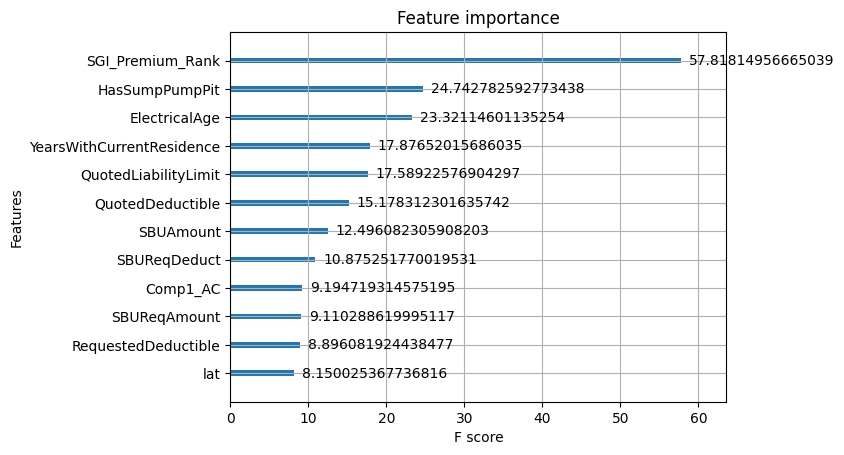

<Figure size 1800x1600 with 0 Axes>

In [65]:
xgb.plot_importance(best_model_unsc, max_num_features=12, importance_type="gain")
plt.figure(figsize=(18, 16))
plt.savefig("feat_imp_unsc.png", format="png")
plt.show()

In [66]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    final_df, df_y, test_size=0.2, random_state=42, stratify=df_y
)
scaler = StandardScaler()
scaled_cols = [
    col for col in numeric_columns if col not in ["success"] + ord_col + binary_col
]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
X_test_scaled[scaled_cols] = scaler.transform(X_test[scaled_cols])
dtrain = DMatrix(data=X_train_scaled, label=y_train, enable_categorical=True)
dtest = DMatrix(data=X_test_scaled, label=y_test, enable_categorical=True)
params = {
    "objective": "binary:logistic",
    "max_depth": 4,
    "alpha": 10,
    "learning_rate": 1.0,
}

results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics="auc",
    early_stopping_rounds=10,
    verbose_eval=True,
    seed=42,
)

best_num_boost_round = results.shape[0]

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=best_num_boost_round,
    evals=[(dtest, "test")],
    early_stopping_rounds=10,
)

y_test_pred = best_model.predict(dtest)
test_accuracy = accuracy_score(y_test, (y_test_pred > 0.5).astype(int))
print("Test Accuracy:", test_accuracy)

[0]	train-auc:0.67684+0.00357	test-auc:0.67601+0.01509
[1]	train-auc:0.73738+0.00328	test-auc:0.73084+0.01364
[2]	train-auc:0.75921+0.00238	test-auc:0.74251+0.01236
[3]	train-auc:0.77638+0.00312	test-auc:0.75242+0.01301
[4]	train-auc:0.78685+0.00196	test-auc:0.75873+0.01300
[5]	train-auc:0.79561+0.00246	test-auc:0.76203+0.01226
[6]	train-auc:0.80225+0.00206	test-auc:0.76520+0.01121
[7]	train-auc:0.80867+0.00228	test-auc:0.76751+0.01185
[8]	train-auc:0.81413+0.00183	test-auc:0.77082+0.01225
[9]	train-auc:0.81939+0.00187	test-auc:0.77106+0.01049
[10]	train-auc:0.82311+0.00195	test-auc:0.77323+0.01144
[11]	train-auc:0.82659+0.00220	test-auc:0.77440+0.01085
[12]	train-auc:0.82961+0.00166	test-auc:0.77439+0.01032
[13]	train-auc:0.83274+0.00120	test-auc:0.77511+0.01019
[14]	train-auc:0.83599+0.00118	test-auc:0.77465+0.00942
[15]	train-auc:0.83865+0.00097	test-auc:0.77468+0.00936
[16]	train-auc:0.84183+0.00078	test-auc:0.77359+0.00986
[17]	train-auc:0.84437+0.00068	test-auc:0.77428+0.00966
[1

Test Accuracy: 0.9524113928546062
Test Accuracy: 0.9524113928546062

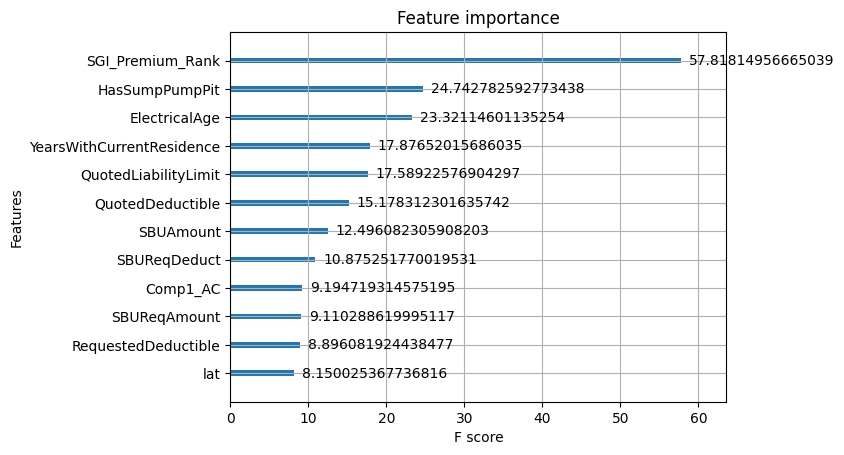

<Figure size 1800x1600 with 0 Axes>

In [67]:
xgb.plot_importance(best_model, max_num_features=12, importance_type="gain")
plt.figure(figsize=(18, 16))
plt.savefig("feat_imp.png", format="png")
plt.show()

In [70]:
importances = best_model.get_score(importance_type="gain")
top_12 = {}
# Sort the features by importance and print them
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
for indx, imp in enumerate(sorted_importances):
    top_12[imp[0]] = imp[1]
    if indx == 11:
        break

In [71]:
top_12

{'SGI_Premium_Rank': 57.81814956665039,
 'HasSumpPumpPit': 24.742782592773438,
 'ElectricalAge': 23.32114601135254,
 'YearsWithCurrentResidence': 17.87652015686035,
 'QuotedLiabilityLimit': 17.58922576904297,
 'QuotedDeductible': 15.178312301635742,
 'SBUAmount': 12.496082305908203,
 'SBUReqDeduct': 10.875251770019531,
 'Comp1_AC': 9.194719314575195,
 'SBUReqAmount': 9.110288619995117,
 'RequestedDeductible': 8.896081924438477,
 'lat': 8.150025367736816}

In [79]:
h2o.init()
h2o_df = h2o.H2OFrame(pd.concat([pd.concat([X_train, X_test], axis=0), df_y], axis=1))
features = [k for k, v in top_12.items()]
target = "success"
train_df, test_df = h2o_df.split_frame(ratios=[0.8], seed=42)
train_df[target] = train_df[target].asfactor()
test_df[target] = test_df[target].asfactor()
aml = H2OAutoML(max_runtime_secs=650)
aml.train(x=features, y=target, training_frame=train_df)

# Print the AutoML leaderboard
lb = aml.leaderboard
print(lb)

# Get the best model
best_model_h2o_unsc = aml.leader

# Make predictions with the best model
predictions_unsc = best_model_h2o_unsc.predict(test_df)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\Tolu\miniconda3\envs\sgi\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Tolu\AppData\Local\Temp\tmpwuxkoc1r
  JVM stdout: C:\Users\Tolu\AppData\Local\Temp\tmpwuxkoc1r\h2o_Tolu_started_from_python.out
  JVM stderr: C:\Users\Tolu\AppData\Local\Temp\tmpwuxkoc1r\h2o_Tolu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       America/Toronto
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.3
H2O_cluster_version_age:    13 days
H2O_cluster_name:           H2O_from_python_Tolu_8u1hdh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.990 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.16 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:19:59.563: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_AllModels_3_AutoML_1_20230904_231959     0.773249   0.16583   0.165602                0.366332  0.204694  0.0418995
StackedEnsemble_AllModels_4_AutoML_1_20230904_231959     0.772598   0.165922  0.165114                0.362974  0.204717  0.0419092
GBM_grid_1_AutoML_1_20230904_231959_model_9              0.771941   0.166117  0.165871                0.347777  0.204672  0.0418908
StackedEnsemble_BestOfFamily_4_AutoML_1_20230904_231959  0.771674   0.166052  0.164754                0.373019  0.20475   0.0419225
GBM_grid_1_AutoML_1_20230904_231959_model_5              0.771674   0.166216  0.165443 

In [81]:
best_model_h2o_unsc

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20230904_231959


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       16/44
# GBM base models (used / total)           11/37
# GLM base models (used / total)           1/1
# DeepLearning base models (used / total)  2/4
# DRF base models (used / total)           2/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.03700950951965494
RMSE: 0.19237855784794453
LogLoss: 0.14632312271132977
AUC: 0.8178041449635702
AUCPR: 0.19944844813468374
Gini: 0.6356082899271405
Null degrees of freedom: 10015
Residual degrees of freedom: 9999
Null deviance: 3516.2745174893385
Residual deviance: 2931.1447941533584
AIC: 2965.1447941533584

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13424238466023053
       0     1    Error    Rate
-----  ----  ---  -------  ---------------
0      9053  539  0.0562   (539.0/9592.0)
1      267   157  0.6297   (267.0/424.0)
Total  9320  696  0.0805   (806.0/10016.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.134242     0.280357  150
max f2                       0.0765418    0.365041  220
max f0point5                 0.195204     0.284223  102
max accuracy                 0.491235     0.957867  3
max precision                0.565925     1         0
max recall                   0.00846208   1         385
max specificity              0.565925     1         0
max absolute_mcc             0.134242     0.248702  150
max min_per_class_accuracy   0.0476267    0.731547  272
max mean_per_class_accuracy  0.0415042    0.751919  285
max tns                      0.565925     9592      0
max fns                      0.565925     423       0
max fps                      0.0034917    9592      399
max tps                      0.00846208   424       385
max tnr                      0.565925     1         0
max fnr                      0.565925     0.997642  0
max fpr                      0.0034917    1         399
max tpr                      0.00846208   1         385

Gains/Lift Table: Avg response rate:  4.23 %, avg score:  4.63 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100839                   0.282854           7.71829    7.71829            0.326733         0.346002    0.326733                    0.346002            0.0778302       0.0778302                  671.829   671.829            0.0707409
2        0.0200679                   0.224863           7.79547    7.75669            0.33             0.249537    0.328358                    0.29801             0.0778302       0.15566                    679.547   675.669            0.141586
3        0.0300519                   0.198535           5.19698    6.90629            0.22             0.21036     0.292359                    0.26889             0.0518868       0.207547                   419.698   590.629            0.185341
4        0.0400359                   0.182246        

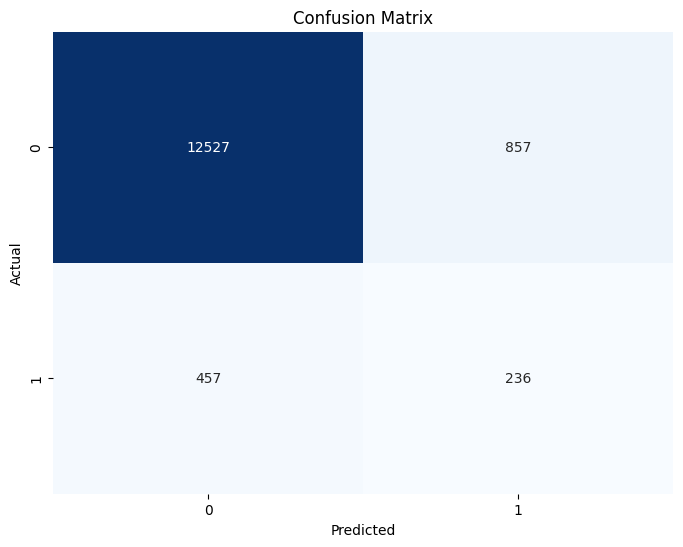

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     13384
           1       0.22      0.34      0.26       693

    accuracy                           0.91     14077
   macro avg       0.59      0.64      0.61     14077
weighted avg       0.93      0.91      0.92     14077



In [100]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert the H2O frame with predictions into a Pandas DataFrame
predictions_df = predictions_unsc.as_data_frame()
test_vals = test_df["success"].as_data_frame()

# Create a confusion matrix to compare actual vs. predicted values
confusion = confusion_matrix(test_vals, predictions_df["predict"])

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Optionally, you can calculate and print classification metrics (e.g., accuracy, precision, recall, F1-score)
from sklearn.metrics import classification_report

classification_metrics = classification_report(test_vals, predictions_df["predict"])
print(classification_metrics)

In [80]:
h2o.init()

h2o_df = h2o.H2OFrame(
    pd.concat([pd.concat([X_train_scaled, X_test_scaled], axis=0), df_y], axis=1)
)
features = [k for k, v in top_12.items()]
target = "success"
train_df, test_df = h2o_df.split_frame(ratios=[0.8], seed=42)
train_df[target] = train_df[target].asfactor()
test_df[target] = test_df[target].asfactor()
aml = H2OAutoML(max_runtime_secs=650)
aml.train(x=features, y=target, training_frame=train_df)

# Print the AutoML leaderboard
lb = aml.leaderboard
print(lb)

# Get the best model
best_model_h2o = aml.leader

# Make predictions with the best model
predictions = best_model_h2o.predict(test_df)

# Shutdown H2O cluster
# h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         11 mins 17 secs
H2O_cluster_timezone:       America/Toronto
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.3
H2O_cluster_version_age:    13 days
H2O_cluster_name:           H2O_from_python_Tolu_8u1hdh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.736 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.16 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
23:31:50.736: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_AllModels_3_AutoML_2_20230904_233150     0.773046   0.165808  0.165548                0.355588  0.204668  0.0418891
StackedEnsemble_AllModels_4_AutoML_2_20230904_233150     0.772832   0.16584   0.165333                0.353014  0.204688  0.0418971
GBM_grid_1_AutoML_2_20230904_233150_model_12             0.772649   0.166169  0.164227                0.368772  0.204794  0.0419407
GBM_grid_1_AutoML_2_20230904_233150_model_2              0.771929   0.166336  0.162718                0.354701  0.204888  0.0419791
GBM_grid_1_AutoML_2_20230904_233150_model_32             0.77144    0.166209  0.163869 

In [102]:
best_model_h2o_unsc

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_2_20230904_233150


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       14/45
# GBM base models (used / total)           10/37
# GLM base models (used / total)           1/1
# DeepLearning base models (used / total)  3/5
# DRF base models (used / total)           0/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04134554136265799
RMSE: 0.20333603065531203
LogLoss: 0.15987321732464838
AUC: 0.8160811087865647
AUCPR: 0.22386369952365573
Gini: 0.6321622175731294
Null degrees of freedom: 9948
Residual degrees of freedom: 9934
Null deviance: 3840.9923324412275
Residual deviance: 3181.157278325854
AIC: 3211.157278325854

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13827448028548428
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      8962  508  0.0536   (508.0/9470.0)
1      305   174  0.6367   (305.0/479.0)
Total  9267  682  0.0817   (813.0/9949.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.138274     0.299742  145
max f2                       0.0778849    0.405056  220
max f0point5                 0.223115     0.302178  81
max accuracy                 0.449736     0.952257  10
max precision                0.557341     0.666667  2
max recall                   0.00729785   1         389
max specificity              0.60097      0.999894  0
max absolute_mcc             0.101806     0.270114  184
max min_per_class_accuracy   0.0489882    0.740127  268
max mean_per_class_accuracy  0.0489882    0.740627  268
max tns                      0.60097      9469      0
max fns                      0.60097      479       0
max fps                      0.002722     9470      399
max tps                      0.00729785   479       389
max tnr                      0.60097      0.999894  0
max fnr                      0.60097      1         0
max fpr                      0.002722     1         399
max tpr                      0.00729785   1         389

Gains/Lift Table: Avg response rate:  4.81 %, avg score:  4.72 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100513                   0.290453           9.34666    9.34666            0.45             0.357352    0.45                        0.357352            0.0939457       0.0939457                  834.666   834.666            0.0881379
2        0.020002                    0.236398           5.45484    7.41053            0.262626         0.261923    0.356784                    0.309877            0.0542797       0.148225                   445.484   641.053            0.134709
3        0.0300533                   0.202891           5.40029    6.73821            0.26             0.21769     0.324415                    0.279046            0.0542797       0.202505                   440.029   573.821            0.181175
4        0.040004                    0.184045           4.

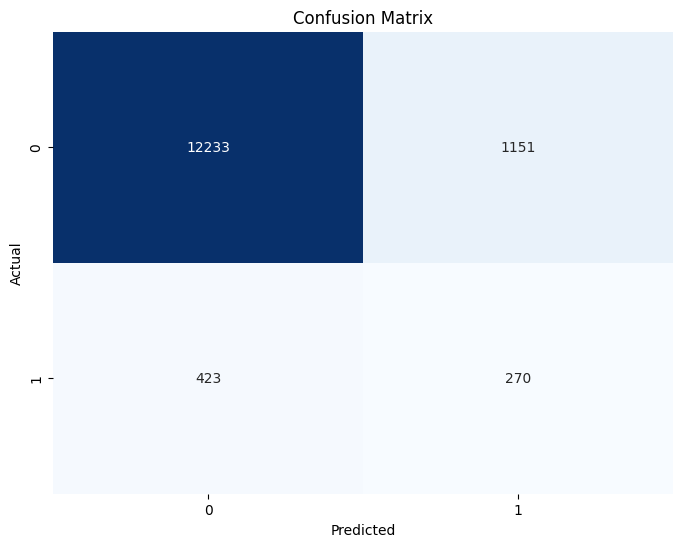

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     13384
           1       0.19      0.39      0.26       693

    accuracy                           0.89     14077
   macro avg       0.58      0.65      0.60     14077
weighted avg       0.93      0.89      0.91     14077



In [101]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert the H2O frame with predictions into a Pandas DataFrame
predictions_df = predictions.as_data_frame()

# Create a confusion matrix to compare actual vs. predicted values
confusion = confusion_matrix(test_vals, predictions_df["predict"])

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Optionally, you can calculate and print classification metrics (e.g., accuracy, precision, recall, F1-score)
from sklearn.metrics import classification_report

classification_metrics = classification_report(test_vals, predictions_df["predict"])
print(classification_metrics)

In [103]:
best_model_h2o_unsc

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20230904_231959


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       16/44
# GBM base models (used / total)           11/37
# GLM base models (used / total)           1/1
# DeepLearning base models (used / total)  2/4
# DRF base models (used / total)           2/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.03700950951965494
RMSE: 0.19237855784794453
LogLoss: 0.14632312271132977
AUC: 0.8178041449635702
AUCPR: 0.19944844813468374
Gini: 0.6356082899271405
Null degrees of freedom: 10015
Residual degrees of freedom: 9999
Null deviance: 3516.2745174893385
Residual deviance: 2931.1447941533584
AIC: 2965.1447941533584

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13424238466023053
       0     1    Error    Rate
-----  ----  ---  -------  ---------------
0      9053  539  0.0562   (539.0/9592.0)
1      267   157  0.6297   (267.0/424.0)
Total  9320  696  0.0805   (806.0/10016.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.134242     0.280357  150
max f2                       0.0765418    0.365041  220
max f0point5                 0.195204     0.284223  102
max accuracy                 0.491235     0.957867  3
max precision                0.565925     1         0
max recall                   0.00846208   1         385
max specificity              0.565925     1         0
max absolute_mcc             0.134242     0.248702  150
max min_per_class_accuracy   0.0476267    0.731547  272
max mean_per_class_accuracy  0.0415042    0.751919  285
max tns                      0.565925     9592      0
max fns                      0.565925     423       0
max fps                      0.0034917    9592      399
max tps                      0.00846208   424       385
max tnr                      0.565925     1         0
max fnr                      0.565925     0.997642  0
max fpr                      0.0034917    1         399
max tpr                      0.00846208   1         385

Gains/Lift Table: Avg response rate:  4.23 %, avg score:  4.63 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100839                   0.282854           7.71829    7.71829            0.326733         0.346002    0.326733                    0.346002            0.0778302       0.0778302                  671.829   671.829            0.0707409
2        0.0200679                   0.224863           7.79547    7.75669            0.33             0.249537    0.328358                    0.29801             0.0778302       0.15566                    679.547   675.669            0.141586
3        0.0300519                   0.198535           5.19698    6.90629            0.22             0.21036     0.292359                    0.26889             0.0518868       0.207547                   419.698   590.629            0.185341
4        0.0400359                   0.182246        